In [1]:
#Import some modules
%matplotlib inline
import numpy as np
import pandas as pd
import utils as ut
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split



#Load in the data
df1 = pd.read_csv('LoanStats3a.csv', skiprows = 1, 
                  parse_dates = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d'],
                 skipfooter = 2)
df2 = pd.read_csv('LoanStats3b.csv', skiprows = 1, 
                  parse_dates = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d'],
                 skipfooter = 2, infer_datetime_format=True)
df3 = pd.read_csv('LoanStats3c.csv', skiprows = 1, 
                  parse_dates = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d'],
                 skipfooter = 2, infer_datetime_format=True)
df4 = pd.read_csv('LoanStats3d.csv', skiprows = 1, 
                  parse_dates = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d'],
                 skipfooter = 2, infer_datetime_format=True)

loans = pd.concat([df1, df2, df3, df4], ignore_index = True)

del df1
del df2
del df3
del df4

/Users/jared/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:15: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skip_footer; you can avoid this warning by specifying engine='python'.
/Users/jared/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:18: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skip_footer; you can avoid this warning by specifying engine='python'.
/Users/jared/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:21: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skip_footer; you can avoid this warning by specifying engine='python'.
/Users/jared/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:24: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skip_footer

In [2]:
#Change 'does not meet...' fields 
loans.replace(to_replace = 'Does not meet the credit policy. Status:Fully Paid', value = 'Fully Paid', inplace = True)
loans.replace(to_replace = 'Does not meet the credit policy. Status:Charged Off', value = 'Charged Off', inplace = True)

#Assign default to charged off
loans.replace(to_replace = 'Default', value = 'Charged Off', inplace = True)

In [3]:
#Filter out everything but 'fully paid' and 'charged off'
loans = loans[(loans.loan_status == 'Fully Paid') | (loans.loan_status == 'Charged Off')]

In [4]:
#annual_inc is null in four places where a whole bunch of other values are null
#drop the four null entries for annual_inc
loans.dropna(subset = ['annual_inc'], inplace = True)

In [5]:
#delinq_2yrs, inq_last_6mths, open_acc, pub_rec, total_acc, acc_now_delinq
#all share 25 rows where all are null, drop those rows
loans.dropna(subset = ['delinq_2yrs', 'inq_last_6mths', 
                      'open_acc', 'pub_rec', 'acc_now_delinq'], inplace = True)

In [6]:
#116 null values in collections_12_mths_ex_med, set those to the median value
loans.collections_12_mths_ex_med.fillna(loans.collections_12_mths_ex_med.median(), inplace = True)

In [7]:
#Clean home_ownership
#There is one loan with home_ownwership == 'ANY', add that to 'OTHER'
loans.home_ownership.replace(to_replace = 'ANY', value = 'OTHER', inplace = True)

In [8]:
#Clean emp_length
#Create a dictionary to change the year strings into numbers
year_dict = {'emp_length':{'10+ years':10, '< 1 year':0, '3 years':3, '9 years':9, '4 years':4, '5 years':5,
       '1 year':1, '6 years':6, '2 years':2, '7 years':7, '8 years':8, 'n/a':-1}}
#Replace the year strings with numbers
loans.replace(year_dict, inplace = True)

In [9]:
#Clean revol_util
#nans are rare, there are no zeros, pretty sure nan is either a zero or decline to report
#replace nans with 0%
loans.revol_util.fillna('0%', inplace = True)

#Create a dictionary to convert revol_util strings to floats
revol_ut_dict = {revol_ut: float(revol_ut[0:-1]) for revol_ut in loans.revol_util.unique()}

#Replace string revol_util with floats
loans.replace(to_replace = {'revol_util': revol_ut_dict}, inplace = True)

In [10]:
#Process the dates
base_time = dt.datetime.now()
#Parse the dates into datetime objects
cr_line = ut.parse_date_series(loans.earliest_cr_line)
pl_date = ut.parse_date_series(loans.last_credit_pull_d)

In [11]:
#Fill (few) null times with the current time
cr_line.fillna(value = base_time, inplace = True)
pl_date.fillna(value = base_time, inplace = True)

In [12]:
#Get the months since first credit and last credit pull
cr_line_months = ut.months_since(base_time, cr_line)
pl_date_months = ut.months_since(base_time, pl_date)

In [13]:
#Change null values into the means
cr_line_months.replace(to_replace=0, value=cr_line_months.mean(), inplace=True)
pl_date_months.replace(to_replace=0, value=pl_date_months.mean(), inplace=True)

In [14]:
#Add the new columns to the data
loans['erlst_cred'] = cr_line_months
loans['last_cred_pl'] = pl_date_months

del cr_line_months
del pl_date_months

In [15]:
#Read in IRS zipcode data
zip_data = pd.read_pickle('anon_avg_irs_data.pkl')

In [16]:
#Create a dictionary to convert anonomized string zipcodes into integers
code_dict = {code: int(code[0:3]) for code in loans.zip_code.unique()}
#Replace string zipcodes with integer zipcodes
loans.replace(to_replace = {'zip_code': code_dict}, inplace = True)

In [17]:
#Drop unnecessary columns from zipcode data
zip_data.drop(['adj_gross_inc', 'amt_SS', 'amt_edu', 'amt_itemized',
       'amt_mort_intr', 'amt_st_loans', 'amt_unemp', 'n_SS', 'n_edu',
       'n_farm', 'n_itemized', 'n_mort_intr', 'n_returns', 'n_st_loans',
       'n_unemp'], axis = 1, inplace=True)
#Rename the zipcd column so that we can do a join
zip_data.rename(columns = {'zipcd':'zip_code'}, inplace = True)

In [18]:
#Join zipcode data to loan data on zip_code
loans = loans.join(zip_data, on = 'zip_code', rsuffix = 'r')
loans.drop('zip_coder', axis = 1, inplace = True)
del zip_data

In [19]:
#Some zip code data mismatch, fill missing indices with medians
zip_fill_dict = {'avg_inc': loans.avg_inc.median(), 'avg_SS': loans.avg_SS.median(), 
                 'avg_itemized': loans.avg_itemized.median(), 'avg_unemp': loans.avg_unemp.median(),
                 'avg_mort_intr': loans.avg_mort_intr.median(), 'avg_edu': loans.avg_edu.median(),
                 'avg_st_loans': loans.avg_st_loans.median(), 'prop_SS': loans.prop_SS.median(),
                 'prop_itemized': loans.prop_itemized.median(), 'prop_unemp': loans.prop_unemp.median(),
                 'prop_farm': loans.prop_farm.median(), 'prop_mort_intr': loans.prop_mort_intr.median(),
                 'prop_edu': loans.prop_edu.median(), 'prop_st_loans': loans.prop_st_loans.median()}
loans.fillna(value = zip_fill_dict, inplace = True)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,avg_mort_intr,avg_edu,avg_st_loans,prop_SS,prop_itemized,prop_unemp,prop_farm,prop_mort_intr,prop_edu,prop_st_loans
0,1077501,1296599.0,5000.0,5000.0,4975.000000,36 months,10.65%,162.87,B,B2,...,10.762491,1.924419,0.956840,0.096519,0.294366,0.072245,6.766248e-03,0.236607,0.019358,0.095439
1,1077430,1314167.0,2500.0,2500.0,2500.000000,60 months,15.27%,59.83,C,C4,...,6.943484,2.613861,1.033616,0.107855,0.288517,0.060976,2.474951e-03,0.207552,0.011425,0.066625
2,1077175,1313524.0,2400.0,2400.0,2400.000000,36 months,15.96%,84.33,C,C5,...,10.577200,2.579682,1.107968,0.063228,0.261276,0.090446,1.632616e-04,0.195071,0.016173,0.096599
3,1076863,1277178.0,10000.0,10000.0,10000.000000,36 months,13.49%,339.31,C,C1,...,13.314386,2.126733,0.984944,0.077820,0.348774,0.108607,2.547390e-04,0.270798,0.013350,0.060813
5,1075269,1311441.0,5000.0,5000.0,5000.000000,36 months,7.90%,156.46,A,A4,...,11.948597,1.847579,0.978844,0.131628,0.399856,0.059974,9.853996e-04,0.326263,0.018635,0.094218
7,1072053,1288686.0,3000.0,3000.0,3000.000000,36 months,18.64%,109.43,E,E1,...,16.224948,2.187500,1.033117,0.055432,0.266141,0.097907,8.316176e-05,0.152030,0.010104,0.065829
8,1071795,1306957.0,5600.0,5600.0,5600.000000,60 months,21.28%,152.39,F,F2,...,10.958611,1.969444,0.933468,0.104369,0.302070,0.118394,5.216978e-04,0.242813,0.011351,0.071174
9,1071570,1306721.0,5375.0,5375.0,5350.000000,60 months,12.69%,121.45,B,B5,...,9.030859,2.250278,1.024369,0.081780,0.373263,0.055700,1.862762e-02,0.308522,0.015844,0.079372
10,1070078,1305201.0,6500.0,6500.0,6500.000000,60 months,14.65%,153.45,C,C3,...,9.909097,1.830481,0.942112,0.146695,0.342892,0.082828,1.436057e-03,0.284663,0.015023,0.080841
11,1069908,1305008.0,12000.0,12000.0,12000.000000,36 months,12.69%,402.54,B,B5,...,15.780425,1.981829,0.994504,0.100362,0.425365,0.103193,3.538255e-04,0.330313,0.013464,0.060862


In [20]:
#Drop all columns not being used
drop_list = ['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
            'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'verification_status', 'issue_d',
            'pymnt_plan', 'url', 'desc', 'title', 'zip_code', 'addr_state', 'earliest_cr_line', 'initial_list_status',
            'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
            'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
            'next_pymnt_d', 'last_credit_pull_d', 'policy_code', 'application_type', 'annual_inc_joint',
            'dti_joint', 'verification_status_joint', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m', 'open_il_12m',
            'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m',
            'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m','max_bal_bc', 'all_util',
            'inq_fi', 'total_fi_tl', 'inq_last_12m']
loans.drop(drop_list, axis = 1, inplace = True)

In [21]:
#Change categorical variables into indicator variables
#Change loan status to a number "charged off" is signal, so 1, "fully paid" is 0
loans.replace({'loan_status': {'Fully Paid':0, 'Charged Off':1}}, inplace = True)
#Change home_ownership variables (leaving NONE out)
loans['has_mortgage'] = pd.Series(data=loans.home_ownership == 'MORTGAGE', index=loans.index)
loans['has_rent'] = pd.Series(data=loans.home_ownership == 'RENT', index=loans.index)
loans['has_own'] = pd.Series(data=loans.home_ownership == 'OWN', index=loans.index)
loans['has_other'] = pd.Series(data=loans.home_ownership == 'OTHER', index=loans.index)
#Change purpose varaiables (leaving out 'educational)
loans['for_car'] = pd.Series(data=loans.purpose == 'car', index=loans.index)
loans['for_cc'] = pd.Series(data=loans.purpose == 'credit_card', index=loans.index)
loans['for_debt'] = pd.Series(data=loans.purpose == 'debt_consolidation', index=loans.index)
loans['for_home_imp'] = pd.Series(data=loans.purpose == 'home_improvement', index=loans.index)
loans['for_house'] = pd.Series(data=loans.purpose == 'house', index=loans.index)
loans['for_purchase'] = pd.Series(data=loans.purpose == 'major_purchase', index=loans.index)
loans['for_med'] = pd.Series(data=loans.purpose == 'medical', index=loans.index)
loans['for_move'] = pd.Series(data=loans.purpose == 'moving', index=loans.index)
loans['for_other'] = pd.Series(data=loans.purpose == 'other', index=loans.index)
loans['for_energy'] = pd.Series(data=loans.purpose == 'renewable_energy', index=loans.index)
loans['for_business'] = pd.Series(data=loans.purpose == 'small_business', index=loans.index)
loans['for_vacation'] = pd.Series(data=loans.purpose == 'vacation', index=loans.index)
loans['for_wedding'] = pd.Series(data=loans.purpose == 'wedding', index=loans.index)
#Drop purpose and home_ownership columns
loans.drop(['purpose', 'home_ownership'], axis = 1, inplace = True)

In [28]:
#Months since last delinquency
#136590 null values (means no last delinquency)
len(loans[loans.mths_since_last_delinq.isnull()].mths_since_last_delinq)

136590

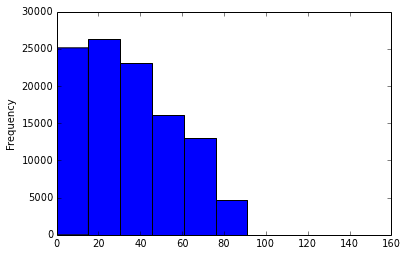

In [29]:
loans.mths_since_last_delinq.plot(kind = 'hist')

In [34]:
#Get quantiles for months since last delinquency
quant = loans.mths_since_last_delinq.quantile(q=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
quant

0.1     8.0
0.2    14.0
0.3    19.0
0.4    26.0
0.5    32.0
0.6    39.0
0.7    47.0
0.8    56.0
0.9    68.0
Name: mths_since_last_delinq, dtype: float64

In [46]:
#Create new series to act as dummy variables for months since last delinquency quantile
loans['mnths_since_delinq_1st'] = pd.Series(data=loans.mths_since_last_delinq <= quant[0.1], index=loans.index)
loans['mnths_since_delinq_2nd'] = pd.Series(data=(loans.mths_since_last_delinq > quant[0.1]) &
                                            (loans.mths_since_last_delinq <= quant[0.2]), index=loans.index)
loans['mnths_since_delinq_3rd'] = pd.Series(data=(loans.mths_since_last_delinq > quant[0.2]) &
                                            (loans.mths_since_last_delinq <= quant[0.3]), index=loans.index)
loans['mnths_since_delinq_4th'] = pd.Series(data=(loans.mths_since_last_delinq > quant[0.3]) &
                                            (loans.mths_since_last_delinq <= quant[0.4]), index=loans.index)
loans['mnths_since_delinq_5th'] = pd.Series(data=(loans.mths_since_last_delinq > quant[0.4]) &
                                            (loans.mths_since_last_delinq <= quant[0.5]), index=loans.index)
loans['mnths_since_delinq_6th'] = pd.Series(data=(loans.mths_since_last_delinq > quant[0.5]) &
                                            (loans.mths_since_last_delinq <= quant[0.6]), index=loans.index)
loans['mnths_since_delinq_7th'] = pd.Series(data=(loans.mths_since_last_delinq > quant[0.6]) &
                                            (loans.mths_since_last_delinq <= quant[0.7]), index=loans.index)
loans['mnths_since_delinq_8th'] = pd.Series(data=(loans.mths_since_last_delinq > quant[0.7]) &
                                            (loans.mths_since_last_delinq <= quant[0.8]), index=loans.index)
loans['mnths_since_delinq_9th'] = pd.Series(data=(loans.mths_since_last_delinq > quant[0.8]) &
                                            (loans.mths_since_last_delinq <= quant[0.9]), index=loans.index)
loans['mnths_since_delinq_10th'] = pd.Series(data=loans.mths_since_last_delinq > quant[0.9], index=loans.index)


In [ ]:
#Drop mths_since_last_delinq
loans.drop('mths_since_last_delinq', axis = 1, inplace = True)

In [47]:
#Months since last record
#214406 null values (means no last record)
len(loans[loans.mths_since_last_record.isnull()].mths_since_last_record)

214406

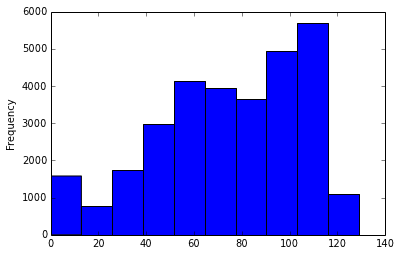

In [48]:
loans.mths_since_last_record.plot(kind = 'hist')

In [49]:
#Get quantiles for months since last record
quant = loans.mths_since_last_record.quantile(q=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
quant

0.1     32.0
0.2     48.0
0.3     58.0
0.4     68.0
0.5     78.0
0.6     89.0
0.7     98.0
0.8    105.0
0.9    112.0
Name: mths_since_last_record, dtype: float64

In [ ]:
#Create new series to act as dummy variables for months since last record quantile
loans['mnths_since_record_1st'] = pd.Series(data=loans.mths_since_last_record <= quant[0.1], index=loans.index)
loans['mnths_since_record_2nd'] = pd.Series(data=(loans.mths_since_last_record > quant[0.1]) &
                                            (loans.mths_since_last_record <= quant[0.2]), index=loans.index)
loans['mnths_since_record_3rd'] = pd.Series(data=(loans.mths_since_last_record > quant[0.2]) &
                                            (loans.mths_since_last_record <= quant[0.3]), index=loans.index)
loans['mnths_since_record_4th'] = pd.Series(data=(loans.mths_since_last_record > quant[0.3]) &
                                            (loans.mths_since_last_record <= quant[0.4]), index=loans.index)
loans['mnths_since_record_5th'] = pd.Series(data=(loans.mths_since_last_record > quant[0.4]) &
                                            (loans.mths_since_last_record <= quant[0.5]), index=loans.index)
loans['mnths_since_record_6th'] = pd.Series(data=(loans.mths_since_last_record > quant[0.5]) &
                                            (loans.mths_since_last_record <= quant[0.6]), index=loans.index)
loans['mnths_since_record_7th'] = pd.Series(data=(loans.mths_since_last_record > quant[0.6]) &
                                            (loans.mths_since_last_record <= quant[0.7]), index=loans.index)
loans['mnths_since_record_8th'] = pd.Series(data=(loans.mths_since_last_record > quant[0.7]) &
                                            (loans.mths_since_last_record <= quant[0.8]), index=loans.index)
loans['mnths_since_record_9th'] = pd.Series(data=(loans.mths_since_last_record > quant[0.8]) &
                                            (loans.mths_since_last_record <= quant[0.9]), index=loans.index)
loans['mnths_since_record_10th'] = pd.Series(data=loans.mths_since_last_record > quant[0.9], index=loans.index)


In [ ]:
#Drop mths_since_last_record
loans.drop('mths_since_last_record', axis = 1, inplace = True)

In [50]:
#Months since last major derogatory record
#200250 null values (means no last record)
len(loans[loans.mths_since_last_major_derog.isnull()].mths_since_last_major_derog)

200250

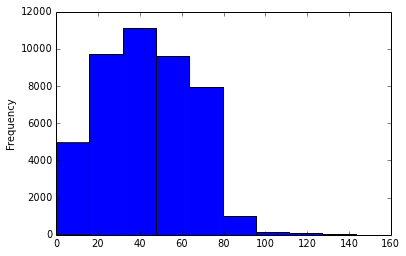

In [52]:
loans.mths_since_last_major_derog.plot(kind = 'hist')

In [53]:
#Get quantiles for months since last major derogatory record
quant = loans.mths_since_last_major_derog.quantile(q=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
quant

0.1    15.0
0.2    23.0
0.3    30.0
0.4    36.0
0.5    43.0
0.6    49.0
0.7    56.0
0.8    64.0
0.9    72.0
Name: mths_since_last_major_derog, dtype: float64

In [ ]:
#Create new series to act as dummy variables for months since last major derogatory record quantile
loans['mnths_since_derog_1st'] = pd.Series(data=loans.mths_since_last_major_derog <= quant[0.1], index=loans.index)
loans['mnths_since_derog_2nd'] = pd.Series(data=(loans.mths_since_last_major_derog > quant[0.1]) &
                                            (loans.mths_since_last_major_derog <= quant[0.2]), index=loans.index)
loans['mnths_since_derog_3rd'] = pd.Series(data=(loans.mths_since_last_major_derog > quant[0.2]) &
                                            (loans.mths_since_last_major_derog <= quant[0.3]), index=loans.index)
loans['mnths_since_derog_4th'] = pd.Series(data=(loans.mths_since_last_major_derog > quant[0.3]) &
                                            (loans.mths_since_last_major_derog <= quant[0.4]), index=loans.index)
loans['mnths_since_derog_5th'] = pd.Series(data=(loans.mths_since_last_major_derog > quant[0.4]) &
                                            (loans.mths_since_last_major_derog <= quant[0.5]), index=loans.index)
loans['mnths_since_derog_6th'] = pd.Series(data=(loans.mths_since_last_major_derog > quant[0.5]) &
                                            (loans.mths_since_last_major_derog <= quant[0.6]), index=loans.index)
loans['mnths_since_derog_7th'] = pd.Series(data=(loans.mths_since_last_major_derog > quant[0.6]) &
                                            (loans.mths_since_last_major_derog <= quant[0.7]), index=loans.index)
loans['mnths_since_derog_8th'] = pd.Series(data=(loans.mths_since_last_major_derog > quant[0.7]) &
                                            (loans.mths_since_last_major_derog <= quant[0.8]), index=loans.index)
loans['mnths_since_derog_9th'] = pd.Series(data=(loans.mths_since_last_major_derog > quant[0.8]) &
                                            (loans.mths_since_last_major_derog <= quant[0.9]), index=loans.index)
loans['mnths_since_derog_10th'] = pd.Series(data=loans.mths_since_last_major_derog > quant[0.9], index=loans.index)


In [ ]:
#Drop mths_since_last_major_derog
loans.drop('mths_since_last_major_derog', axis = 1, inplace = True)

In [54]:
#Total credit revovling
#66254 null values
len(loans[loans.total_credit_rv.isnull()].total_credit_rv)

66254

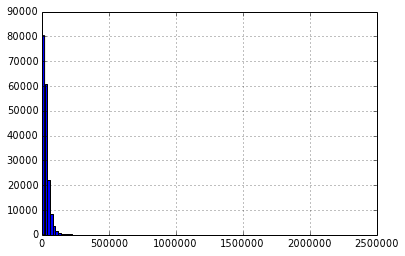

In [58]:
loans.total_credit_rv.hist(bins=100)

In [56]:
loans.total_credit_rv.describe()

count    1.787160e+05
mean     2.957962e+04
std      2.943938e+04
min      0.000000e+00
25%      1.330000e+04
50%      2.220000e+04
75%      3.670000e+04
max      2.013133e+06
Name: total_credit_rv, dtype: float64

In [ ]:
#Mean imputation on total_credit_rv
loans.total_credit_rv.fillna(total_credit_rv.mean(), inplace = True)

In [59]:
#tot_coll_amt
#66254 null values
len(loans[loans.tot_coll_amt.isnull()].tot_coll_amt)

66254

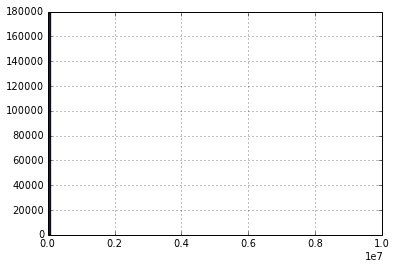

In [60]:
loans.tot_coll_amt.hist(bins=100)

In [61]:
loans.tot_coll_amt.describe()

count    1.787160e+05
mean     2.035719e+02
std      2.171221e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.152545e+06
Name: tot_coll_amt, dtype: float64

In [62]:
loans.tot_coll_amt.quantile(q=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

0.1     0.0
0.2     0.0
0.3     0.0
0.4     0.0
0.5     0.0
0.6     0.0
0.7     0.0
0.8     0.0
0.9    75.0
Name: tot_coll_amt, dtype: float64

In [63]:
#Very little non-zero data, fillna as zero, change to categorical of has_coll
loans.tot_coll_amt.fillna(0, inplace = True)
loans['has_coll'] = pd.Series(data=loans.tot_coll_amt > 0, index=loans.index)

In [64]:
#Drop tot_coll_amt
loans.drop('tot_coll_amt', axis = 1, inplace = True)

In [ ]:
#Pull out the labels and features
labels = loans['loan_status']
features = loans.drop('loan_status', axis = 1)

In [71]:
#Get a test, train, validation split with a 60/20/20 relationship
X_train, X_val_test, y_train, y_val_test = train_test_split(features, labels, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=24)

In [ ]:
#Pull out the categorical values, they don't need to be scaled


In [ ]:
#Normalize the non-categorical data
scaler = StandardScaler()
scaler = scaler.fit(X_train_ncat.values)
X_train_ncat = scaler.transform(X_train_ncat.values)
X_test_ncat = scaler.transform(X_test_ncat.values)
X_val_ncat = scaler.transform(X_val_ncat.values)

In [ ]:
#Put the categorical and non-categorical data back together


In [40]:
X_train.to_pickle('X_train')
y_train.to_pickle('y_train')
X_test.to_pickle('X_test')
y_test.to_pickle('y_test')
X_val.to_pickle('X_val')
y_val.to_pickle('y_val')